In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By

%matplotlib inline

In [2]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

## Utils

In [3]:
def show_img(img, title):
    plt.imshow(img)
    plt.title(title)
    plt.show()

# Contours

In [4]:
URL = "https://ant.design/components/form"
driver.get(URL)
driver.find_element(By.TAG_NAME, 'html').click()

In [5]:
form = driver.find_element(By.ID, 'time_related_controls')
# form = driver.find_elements(By.TAG_NAME, 'form')[0]

In [15]:
# edit colors for better contour detection
labels = form.find_elements(By.TAG_NAME, 'label')
spans = form.find_elements(By.TAG_NAME, 'span')
inputs = form.find_elements(By.TAG_NAME, 'input')
edit_elements = [*labels, *spans, *inputs]

for element in edit_elements:
    driver.execute_script(
        """
            arguments[0].style.color = 'transparent';
            
            /*
            const color = window.getComputedStyle(arguments[0], null).getPropertyValue("color");
            
            arguments[0].style.backgroundColor = color;
            
            let [r, g, b, a] = color.replace('rgba(', '').replace('rgb(', '').replace(')', '').split(',').map(Number)
            a = a || 1;
            r *= a;
            g *= a;
            b *= a;
            const inverted = `rgba(${255 - r}, ${255 - g}, ${255 - b}, ${a})`;
            
            arguments[0].style.border = `2px solid ${inverted}`;
            */
        """,
        element
    )

form_all_children = form.find_elements(By.XPATH, './/*')

for child in form_all_children:
    if child.tag_name != 'None':
        driver.execute_script(
            '''
                arguments[0].style.border = "2px solid black"
            ''',
            child
        )

In [23]:
form.screenshot("temp/temp0.png")

True

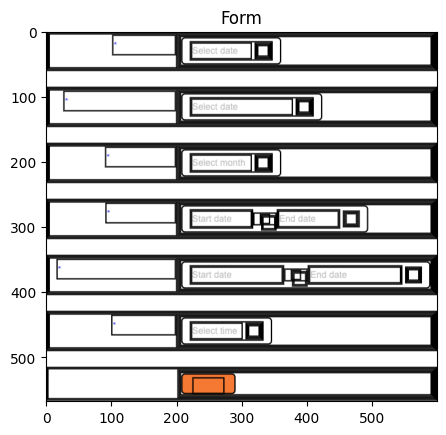

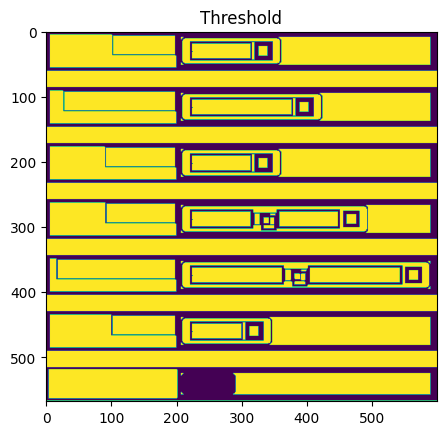

48


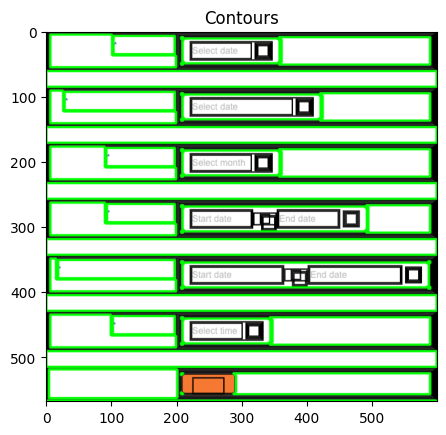

In [24]:
img_color = cv2.imread('temp/temp0.png')
plt.imshow(img_color)
plt.title('Form')
plt.show()

img = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

ret, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

plt.imshow(thresh)
plt.title('Threshold')
plt.show()
bb
contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
print(len(contours))
cv2.drawContours(image=img_color, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

plt.imshow(img_color)
plt.title('Contours')
plt.show()


# First: Text Detection, OCR, and Removal

In [4]:
import cv2
import numpy as np
import pytesseract
from pytesseract import Output

In [14]:
# URL = "https://ant.design/components/form"
# URL = "https://www.amazon.ca/ap/signin?openid.pape.max_auth_age=0&openid.return_to=https%3A%2F%2Fwww.amazon.ca%2Fgp%2Fcss%2Fhomepage.html%2Fref%3Dnav_ya_signin&openid.identity=http%3A%2F%2Fspecs.openid.net%2Fauth%2F2.0%2Fidentifier_select&openid.assoc_handle=caflex&openid.mode=checkid_setup&openid.claimed_id=http%3A%2F%2Fspecs.openid.net%2Fauth%2F2.0%2Fidentifier_select&openid.ns=http%3A%2F%2Fspecs.openid.net%2Fauth%2F2.0&"
URL = "https://react-bootstrap.github.io/forms/input-group/"
driver.get(URL)
driver.find_element(By.TAG_NAME, 'html').click()
# form = driver.find_element(By.ID, 'time_related_controls')
# form = driver.find_elements(By.TAG_NAME, 'form')[0]
form = driver.find_element(By.CLASS_NAME, 'ReactPlayground-StyledExample-module--cls2--Z1-mo ')


In [16]:
w = driver.get_window_size()['width']
driver.set_window_size(w, form.size['height'] + 400)
driver.execute_script("window.scrollTo(0, {0})".format(form.location["y"] - 200))

In [18]:
form.screenshot("temp/temp0.png")

True

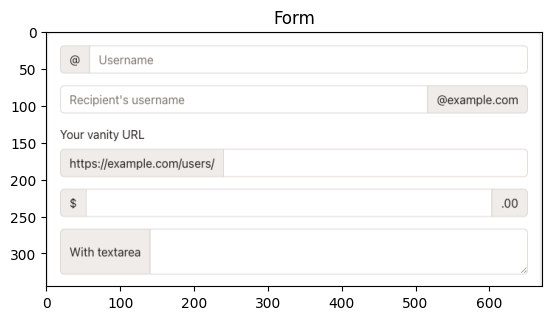

In [19]:
show_img(cv2.imread("temp/temp0.png"), "Form")

In [20]:
# Install tesseract: https://github.com/tesseract-ocr/tesseract
pytesseract.pytesseract.tesseract_cmd = r'/usr/local/bin/tesseract' # Update the path to your tesseract executable

In [21]:
def load_image(file_path):
    image = cv2.imread(file_path)
    orig = image.copy()
    return image, orig

In [22]:
def preprocess_image(image):
    (H, W) = image.shape[:2]
    (newW, newH) = (640, 640)
    rW = W / float(newW)
    rH = H / float(newH)
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]
    return image, rW, rH

In [23]:
def detect_text(image):
    layer_names = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]
    net = cv2.dnn.readNet("frozen_east_text_detection.pb")
    blob = cv2.dnn.blobFromImage(image, 1.0, (640, 640), (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)
    (scores, geometry) = net.forward(layer_names)
    return scores, geometry

In [24]:
def extract_text_boxes(scores, geometry, min_confidence=0.3):
    (num_rows, num_cols) = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(0, num_rows):
        scores_data = scores[0, 0, y]
        x_data0 = geometry[0, 0, y]
        x_data1 = geometry[0, 1, y]
        x_data2 = geometry[0, 2, y]
        x_data3 = geometry[0, 3, y]
        angles_data = geometry[0, 4, y]

        for x in range(0, num_cols):
            if scores_data[x] < min_confidence:
                continue

            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            angle = angles_data[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            h = x_data0[x] + x_data2[x]
            w = x_data1[x] + x_data3[x]

            end_x = int(offsetX + (cos * x_data1[x]) + (sin * x_data2[x]))
            end_y = int(offsetY - (sin * x_data1[x]) + (cos * x_data2[x]))
            start_x = int(end_x - w)
            start_y = int(end_y - h)

            rects.append((start_x, start_y, end_x, end_y))
            confidences.append(scores_data[x])

    return rects, confidences

In [25]:
def perform_ocr(image, rects, confidences, rW, rH, orig, min_confidence=0.5, nms_threshold=0.4):
    indices = cv2.dnn.NMSBoxes(rects, confidences, min_confidence, nms_threshold)
    results = []
    for i in indices:
        (start_x, start_y, end_x, end_y) = rects[i]

        start_x = int(start_x * rW)
        start_y = int(start_y * rH)
        end_x = int(end_x * rW)
        end_y = int(end_y * rH)

        # Extract the region of interest (ROI) for OCR
        roi = orig[start_y:end_y, start_x:end_x]

        # Perform OCR on the ROI
        config = "-l eng --oem 1 --psm 6"
        text = pytesseract.image_to_string(roi, config=config).strip()
        # text = None

        results.append(((start_x, start_y, end_x, end_y), text))

    return results

In [26]:
def draw_results(image, results):
    for (start_x, start_y, end_x, end_y) in results:
        cv2.rectangle(image, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
    show_img(image, "Text Detection")


def draw_results_with_text(image, results):
    for ((start_x, start_y, end_x, end_y), text) in results:
        cv2.rectangle(image, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
        # print(text)
        # cv2.putText(image, text, (start_x, start_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
    show_img(image, "Text Detection")

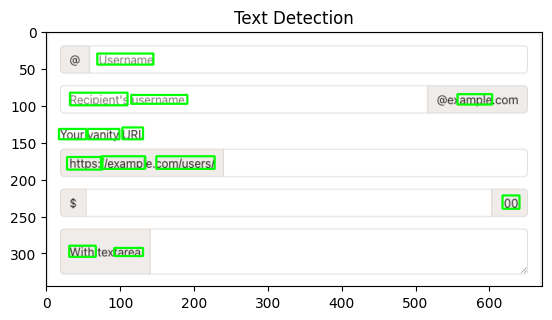

In [27]:
# Load the input image
image, orig = load_image("temp/temp0.png")

# Preprocess the image
image, rW, rH = preprocess_image(image)

# Detect text using EAST text detector
scores, geometry = detect_text(image)

# Extract text regions
rects, confidences = extract_text_boxes(scores, geometry, 0.5)

# Perform OCR on the extracted text regions
results = perform_ocr(image, rects, confidences, rW, rH, orig)

# Draw the results
draw_results_with_text(orig, results)

# Finding Text Elements at Location

In [28]:
def get_element_at_coordinates(driver, x, y):
    script = f"return document.elementFromPoint({x}, {y});"
    element = driver.execute_script(script)
    return element

In [29]:
def get_location_to_point(base_element, rect):
    # Because of the scroll, we always start at y = 200
    base_x, base_y = base_element.location['x'], 200 # base_element.location['y']
    start_x, start_y, end_x, end_y = rect
    
    # x & y is reversed in the webpage
    final_x = base_x + (end_x + start_x) // 2
    final_y = base_y + (end_y + start_y) // 2
    return final_x, final_y

In [30]:
elements = []

for result in results:
    rect = result[0]
    x, y = get_location_to_point(form, rect)
    print(x, y)
    
    element = get_element_at_coordinates(driver, x, y)
    elements.append(((x, y), element))
    '''if element:
        print("Element found at coordinates", x, y)
        print("Tag name:", element.tag_name)
        print("Element attributes:", element.get_attribute('outerHTML'))
    else:
        print("No element found at coordinates", x, y)'''

371 237
375 498
313 497
335 291
368 377
316 378
844 292
417 292
452 377
299 339
341 339
381 338
893 431


In [31]:
results

[((69, 30, 145, 45), 'Username'),
 ((92, 293, 131, 304), 'fares'),
 ((31, 290, 67, 305), 'With'),
 ((32, 83, 110, 100), "Recipient's"),
 ((74, 169, 134, 186), '[lexampl'),
 ((28, 170, 76, 187), 'https:'),
 ((557, 85, 604, 99), 'ample'),
 ((115, 86, 191, 98), 'Lesarname'),
 ((149, 169, 228, 186), 'com/users/'),
 ((17, 132, 54, 146), 'Your'),
 ((56, 132, 99, 146), 'vanity'),
 ((103, 130, 131, 146), 'URL'),
 ((618, 222, 641, 240), '00')]

In [37]:
elements[3][1].get_attribute('outerHTML')

'<input placeholder="Recipient\'s username" aria-label="Recipient\'s username" aria-describedby="basic-addon2" class="form-control">'

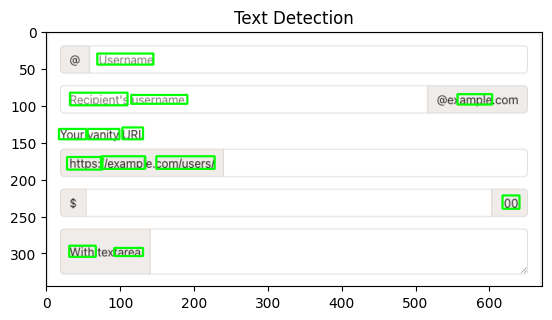

In [34]:
draw_results_with_text(orig, results)